In [ ]:
import os.path
import glob
import shutil

import tensorflow as tf
assert tf.__version__.startswith('2')

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D,Flatten,MaxPooling2D,Dropout,Dense,Activation
from keras import regularizers
import keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2

import numpy as np
import matplotlib.pyplot as plt
import pathlib

In [25]:
BATCH_SIZE = 8 
IMG_HEIGHT = 224 
IMG_WIDTH = 224

In [26]:
DATA_Dir = r"C:\Users\toran\Documents\GitHub\ML_PadiCare\data"
DATA_dir = pathlib.Path(DATA_Dir)
CLASS_NAMES = np.array(['brownspot','healthy','hispa','leafblast'])

print('Class Names: ', CLASS_NAMES)

Class Names:  ['brownspot' 'healthy' 'hispa' 'leafblast']


In [27]:

train_path = r'C:\Users\toran\Documents\GitHub\ML_PadiCare\data\train'
validation_path = r'C:\Users\toran\Documents\GitHub\ML_PadiCare\data\validation'

In [28]:
image_train_gen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.5,
    rotation_range=45,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,  # Added shear range
    brightness_range=[0.8, 1.2],  # Adjust brightness
    fill_mode="nearest"
)

train_data_gen = image_train_gen.flow_from_directory(
    train_path,
    shuffle=True,
    batch_size=BATCH_SIZE,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='sparse'
)

img_val_gen = ImageDataGenerator(rescale=1./255)
val_data_gen = img_val_gen.flow_from_directory(
    validation_path,
    batch_size=BATCH_SIZE,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='sparse'
)


Found 1800 images belonging to 4 classes.
Found 452 images belonging to 4 classes.


In [29]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom layers on top of the pre-trained model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.4)(x)
output = Dense(4, activation='softmax')(x)

# Define the full model
model = Model(inputs=base_model.input, outputs=output)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [30]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),  # Lower learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,619,332 (9.99 MB)

 Trainable params: 361,348 (1.38 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [33]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)


In [34]:
history = model.fit(
    train_data_gen,
    epochs=50,  # Increase epochs for better learning
    validation_data=val_data_gen,
    callbacks=[ reduce_lr]
)


Epoch 1/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 81s 361ms/step - accuracy: 0.4386 - loss: 1.7305 - val_accuracy: 0.2743 - val_loss: 1.9562 - learning_rate: 2.0000e-05
Epoch 2/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 87s 387ms/step - accuracy: 0.4695 - loss: 1.6908 - val_accuracy: 0.2721 - val_loss: 1.9699 - learning_rate: 2.0000e-05
Epoch 3/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 94s 416ms/step - accuracy: 0.4731 - loss: 1.6679 - val_accuracy: 0.3031 - val_loss: 1.9676 - learning_rate: 2.0000e-05
Epoch 4/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 78s 349ms/step - accuracy: 0.4819 - loss: 1.6513 - val_accuracy: 0.2942 - val_loss: 1.9580 - learning_rate: 2.0000e-05
Epoch 5/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 79s 350ms/step - accuracy: 0.4682 - loss: 1.6319 - val_accuracy: 0.2942 - val_loss: 1.9602 - learning_rate: 4.0000e-06
Epoch 6/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 81s 359ms/step - accuracy: 0.4911 - loss: 1.6424 - val_accuracy: 0.2965 - val_loss: 1.9610 - learning_rate: 4.0000e-06
Epoch 7/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 79s 35

KeyboardInterrupt: 

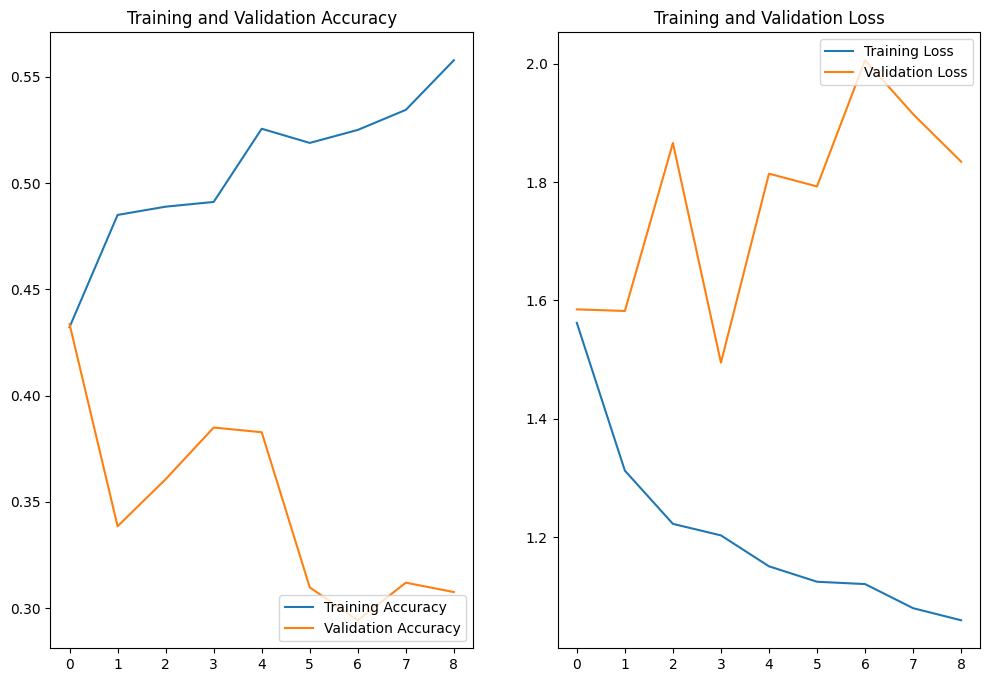

In [19]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_training_history(history)

In [23]:
import ipywidgets as widgets
from IPython.display import display
from tensorflow.keras.utils import load_img, img_to_array
import io
from PIL import Image

# File uploader for prediction
uploader = widgets.FileUpload(accept="image/*", multiple=True)
display(uploader)

# Output widget for displaying predictions
out = widgets.Output()
display(out)

# Function to process and predict each uploaded image
def file_predict(filename, file_content, out):
    """Process and predict the class of a single uploaded image."""
    # Load image from file content
    image = Image.open(io.BytesIO(file_content))
    image = image.resize((IMG_HEIGHT, IMG_WIDTH))  # Resize image
    image_array = img_to_array(image)
    image_array = np.expand_dims(image_array, axis=0) / 255.0  # Normalize

    # Predict
    predictions = model.predict(image_array, verbose=0)
    predicted_class = np.argmax(predictions, axis=1)[0]

    # Map class indices to labels
    class_names = train_data_gen.class_indices
    class_names = {v: k for k, v in class_names.items()}  # Reverse the mapping
    predicted_label = class_names[predicted_class]

    # Display results
    with out:
        print(f"{filename} -> Predicted: {predicted_label}")

# Button for prediction
def on_predict_clicked(change):
    """Handle prediction when button is clicked."""
    with out:
        out.clear_output()
        if uploader.value:
            for file_info in uploader.value:
                filename = file_info['name']
                file_content = file_info['content']
                file_predict(filename, file_content, out)
        else:
            print("Please upload an image for prediction.")

# Predict button
predict_button = widgets.Button(description="Predict")
predict_button.on_click(on_predict_clicked)
display(predict_button)


FileUpload(value=(), accept='image/*', description='Upload', multiple=True)

Output()

Button(description='Predict', style=ButtonStyle())